In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect,func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Another way to Explore the database using inspector
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Get a list of column names and types for 'measurement' table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get a list of column names and types for 'station' table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

Design a query to retrieve the last 12 months of precipitation data and plot the results

In [14]:
# Calculate the date 1 year ago from the last data point in the database
recent_record=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_record)
print(type(recent_record))

# Change the last_date's datatype to string and extract only the date to convert it into
recent_record_str=str(recent_record).split("'")[1]
print(recent_record_str)
print(type(recent_record_str))

# Determine the date point one year from the most recent date
recent_date=dt.datetime.strptime(recent_record_str,"%Y-%m-%d")
last=recent_date-dt.timedelta(days=364)
print(last)
print(type(last))
last_date=last.strftime("%Y-%m-%d")#back to string
print(last_date)

('2017-08-23',)
<class 'sqlalchemy.util._collections.result'>
2017-08-23
<class 'str'>
2016-08-24 00:00:00
<class 'datetime.datetime'>
2016-08-24


In [15]:
# Perform a query to retrieve the data and precipitation scores
prcp_data=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=last_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])
prcp_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [16]:
# Sort the dataframe by date
prcp_df.sort_values(by=["Date"], inplace=True)
prcp_df.dropna(how='any',inplace=True)
prcp_df.head(10)

,Date,Precipitation
0,2016-08-24,0.08
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
1875,2016-08-24,1.45
1188,2016-08-24,1.22
1,2016-08-25,0.08
1007,2016-08-25,0.00
1525,2016-08-25,0.06
703,2016-08-25,0.00


In [17]:
prcp_df.set_index('Date',inplace=True)

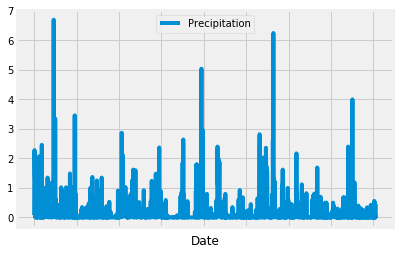

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()
plt.legend(loc='upper center')

plt.savefig("img/PrecipitationAnalysis.png")

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
total_stations=session.query(Station).count()
total_stations

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station=='USC00519281').all()
print(most_active_station)

[(54.0, 85.0, 71.66378066378067)]


In [23]:
# Choose the station with the highest number of temperature observations.
# station : USC00519281
# Query the last 12 months of temperature observation data for this station
tobs_data=session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.date>=last_date,Measurement.station=='USC00519281').all()

In [24]:
# Save the query results as a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'TOBS'])
tobs_df.dropna(how='any',inplace=True)

tobs_df.head()

,Date,TOBS
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


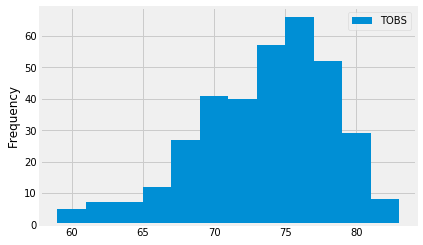

In [25]:
# plot the results as a histogram
tobs_df.plot.hist(bins=12)

plt.savefig("img/TOBs_hitogram.png")

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_temps=calc_temps('2017-02-28', '2017-03-05')
print(prev_temps)

[(64.0, 72.02777777777777, 78.0)]


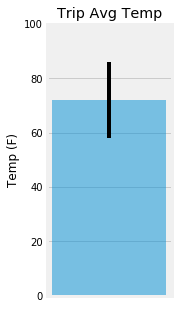

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = prev_temps[0][0]
tavg = prev_temps[0][1]
tmax = prev_temps[0][2]
ptp = tmax-tmin

plt.figure(figsize=(2,5))
plt.bar(1, height=tavg, yerr=ptp, alpha=0.5)
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.savefig("img/TripTempAvg.png")

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prev_year_start = dt.datetime.strptime("2017-02-28", "%Y-%m-%d") - dt.timedelta(days=364)
prev_year_end = dt.datetime.strptime("2017-03-05", "%Y-%m-%d") - dt.timedelta(days=364)

temp = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
prev_year = session.query(*temp).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= prev_year_start).\
    filter(Measurement.date <= prev_year_end).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

print(prev_year)

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [55]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
################################################################
# Set the start and end date of the trip
start = dt.datetime.strptime("2017-02-28", "%Y-%m-%d")
print(start)
end = dt.datetime.strptime("2017-03-05", "%Y-%m-%d")

# Use the start and end date to create a range of dates
date_list = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

for d in date_list:
    print(d.strftime("%Y-%m-%d"))
    
# Stip off the year and save a list of %m-%d strings
mds=[]
for d in date_list:
    print(d.strftime("%m-%d"))
    mds.append(d.strftime("%m-%d"))
print(mds)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for md in mds:
    normals.extend(daily_normals(md))

normals

2017-02-28 00:00:00
2017-02-28
2017-03-01
2017-03-02
2017-03-03
2017-03-04
02-28
03-01
03-02
03-03
03-04
['02-28', '03-01', '03-02', '03-03', '03-04']


[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0)]

In [66]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, index=mds ,columns=['tmin', 'tavg','tmax'])
normals_df.index.name='date'
normals_df

,tmin,tavg,tmax
date,,,
02-28,65.0,70.655172,80.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0


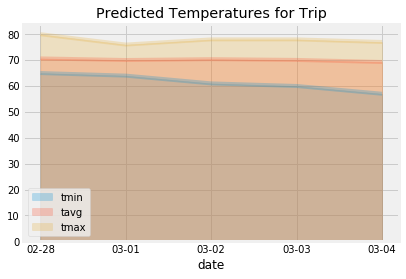

In [86]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area',stacked=False,title='Predicted Temperatures for Trip',alpha=0.25)

x_axis = np.arange(len(mds))
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, mds)

plt.savefig("img/normals_area.png")